# Bug triage with Deep Learning

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 40 # 40
MAX_SEQUENCE_LENGTH_D = 200 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
# Domain to use
DOMAIN = 'eclipse'
# Dataset paths
DIR = 'data/processed/{}'.format(DOMAIN)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Log keras
LOG_DIR='logs/training'
# Checkpoint keras
FILE_PATH = "checkpoint_baseline_1000epoch_10steps_1024batch({})".format(DOMAIN)
# Save model
SAVE_PATH = 'baseline_100epoch_512steps_512batch({})'.format(DOMAIN)

In [8]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

#### Loading bug ids in memory

In [9]:
baseline.load_ids(DIR)
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [10]:
%%time

baseline.load_preprocess()
len(baseline.sentence_dict)


CPU times: user 39 s, sys: 1.52 s, total: 40.6 s
Wall time: 40.4 s


## Geração de batches

### Generating tiple of batches

In [11]:
%%time
baseline.prepare_dataset()

Reading train data
Reading the test...



Reading test data
CPU times: user 479 ms, sys: 12.1 ms, total: 491 ms
Wall time: 485 ms


In [12]:
baseline.load_bugs()

In [13]:
baseline.bug_set[2521]

{'bug_severity': '3\n',
 'bug_status': '0\n',
 'component': '633\n',
 'creation_ts': '2001-10-10 22:38:00 -0400',
 'delta_ts': '2005-05-10 14:55:51 -0400',
 'description': 'steps minimize all your windows go to any window and select the window menu pick any window notice that it only gets selected and not maximized this happens in country as well notes',
 'description_word': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,

In [14]:
%%time

batch_size = 64
batch_size_test = 128

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(baseline.train_data, baseline.dup_sets_train, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(baseline.train_data, 
                                                                                          baseline.dup_sets_train, 
                                                                                          batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description'],
            valid_input_sample['info'], valid_input_pos['info'], valid_input_neg['info']], valid_sim)

CPU times: user 38.7 ms, sys: 3.89 ms, total: 42.6 ms
Wall time: 42.3 ms


In [15]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_input_sample['info'].shape, valid_sim.shape

((128, 40), (128, 200), (128, 1682), (128,))

### Validar entrada

In [16]:
%%time 

baseline.display_batch(baseline.train_data, baseline.dup_sets_train, 5)

***Title***: new configuration option always refresh prior to organization operation
***Title***: organization refresh before organization xxx operations
***Description***: i would like to see a new configuration option always refresh prior to cvs operation proper place should be organization
***Description***: cardinal tripwire i stumble across is that a artwork is not forced before i do team xxx operations i have a number of cases where files under organization in organization are updated from outside organization ã yvind
***similar = 1
########################
***Title***: warns may be null erroneously for variable inside try block
***Title***: compiler null false positives in try finally
***Description***: here s a simple correct block of code to un gzip a file in person person ma flags the while line with a warning indicating that is may be null it s not hard to imagine why a try block confuses person but it s clearly never null the compiler should analyze method calls in the try 

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [171]:
vocab = load_vocabulary(os.path.join(DIR, 'word_vocab.pkl'))
for token in vocab:
    print(token)

vocabulary loaded
servic
openwin
iole
offsets
unhappy
xeac
nguyer
remmethod
invalidation
c
promoting
gabriel
notified
martinperson
ndspod
ambiguities
submits
fbe
wastes
pink
rectangle
cygdrive
jclass
jumping
xmlstream
vers
stakeholders
pwebster
binders
pac
stract
miinferior
ink
functions
liblocalfile
analexee
gemini
part
converting
love
hishape
th
swapped
warn
formally
radix
xbbc
took
maintain
ohf
vtterminal
os
eine
ghandle
cba
allusersprofile
openejb
domast
collaborative
icedtea
vertically
unaware
cleans
disks
convert
sqlexception
rom
ecfplugin
centering
vnode
jkr
consisting
xbeb
leaks
incorrect
wli
spr
sel
sss
reboot
accuracy
nothing
mdl
objectpersoner
mca
executors
eenum
move
workflows
confirm
localize
descripto
hlmerge
elimination
itree
packageview
finer
xfffada
ernel
informing
mysql
targets
tmf
obsolete
enu
reparenting
libexec
inadvertantly
javadocexport
mmip
html
spaces
statuses
inconsistant
xtools
supress
quoting
accessibility
ievaluation
hu
collection
colliding
sence
three
xmli

cvsorganization
installs
abstracts
facetedorganization
pick
interaction
actionpersoner
supportability
platfo
lined
supers
iworkspace
awt
planty
xcc
semantic
khcheung
foreground
cardinalelse
deficiency
reddot
crash
classification
pinpoint
rmdir
benchmarking
jkca
bookstore
adapterorganization
fiwto
formater
fred
orted
back
sqlexplorer
ioe
teprpsdb
sudo
sca
cue
overwrites
cdi
backends
domexception
reinstalled
engage
across
fastviews
activate
grief
specfile
osgiservices
milestones
wsilj
decorator
hyper
exe
documen
programmieren
adt
resourceperson
exhibits
branded
lay
ihas
slave
sqlscrapbook
nonnull
shrunk
standardcountry
load
sight
gitapi
generalization
layers
jsdebug
az
replacer
assembling
launchorganization
instantiate
sdview
xffffe
httporganization
uniformly
svnnature
gitk
stop
odbc
fefd
tracking
confidence
opm
iqueryable
techpreview
basket
pong
illegalorganization
bk
reporunnable
favour
vn
mhurd
trigger
viewpart
saveables
azureus
unassigned
jpars
james
joins
aaabb
process
personon
aeth

pallete
mergers
her
underlined
rsecore
classworlds
submenus
deferredorganizations
thai
article
egl
outcome
survey
national
andre
wtpproject
dae
footers
anon
prior
discouraged
cgi
lotussoap
unquoted
emit
contributed
jobject
ncpwin
reverted
max
viewmodel
favorites
releasable
commandperson
emfdomadapter
lhs
sslorganization
src
hq
befores
differnt
menu
automaticly
inet
xfae
exeption
assist
utfload
tester
stale
creconciling
jikes
yz
omg
seam
cone
painfully
forever
wsddartifact
grid
spelling
organizationt
dataextraction
xxxxxxxxxx
finden
vektor
progess
tck
equiv
bbd
infomation
structure
remedy
ejscontainer
howto
subapplication
bug
iprofile
mbs
aligns
land
deviation
new
warm
demux
nsdocument
labelorganization
permits
cardinal
customer
eglmof
implies
concerning
aeb
pda
relational
shrinking
dow
oml
decoded
fgpq
conveniently
screen
unpredictably
birtreport
sra
drain
ssia
beaninfo
strange
imagine
productorganization
archiving
udb
inactivity
inches
interrupts
satisfactory
subclass
sftp
lyo
proce
i

checkers
attlist
reads
wanted
meeting
oasis
tight
xefb
textually
configure
recompilation
externaltype
insufficient
dice
secret
cfunction
desktop
rainbow
payroll
confusing
bin
cfg
detailing
skipping
uielement
sensitivity
init
xmlstring
rank
myfaces
myfile
echiang
backported
aefc
local
cartridge
linz
scheduled
etc
donate
cvsnonblocking
xd
displaced
rts
recipient
capital
sake
staticperson
nfo
attched
take
eventhandler
thx
avaiable
pluginorganization
xmlresource
resu
ramaster
insert
conversation
antsupportlib
cntl
colour
ž
western
guys
iaction
bcd
resolveorganization
calendars
iproblem
deprecation
improved
accelerate
jvmdumpi
hotbug
googling
excel
odaconsumer
organizationed
hashed
stdout
runnning
mentionned
cocoon
activ
makefile
fds
cndev
jakarta
phtml
caching
perl
xabef
rptlibrary
revison
misleading
erase
guest
ation
noimplement
opsj
statemachine
carries
mortbay
iostrategy
invalidations
unstable
np
personproject
detect
xfffecd
news
geography
domtree
thread
rjvm
xulrunner
rotating
ideas
ac

someorganization
xcffff
killfocus
mapfre
tax
personfile
unfiltered
bad
dig
diagnosed
smoketest
lgui
certification
xefc
singular
lately
idevice
grounp
xml
modifier
viewsvn
cmp
testmodel
contexts
pdq
multiplicity
fillorganization
emphasis
informative
wsant
myserver
ala
cursors
psftci
constorganization
hangs
slp
ancestor
resync
checked
dosen
modifying
sequenced
jpadeployer
astnode
pooled
use
opposites
incredibly
ffd
scm
dbug
lta
jul
trouble
gump
chose
picker
libnio
rhio
accumulating
euc
clutters
dmodel
entryperson
piprocess
bottleneck
donâ
cvsignore
jzentry
soapfault
staying
wouldnt
libplds
statment
ctfadaptor
spam
aeef
rat
prerequisites
rpmlint
rjava
apppersoner
systemperson
deferring
libgobject
exercise
judge
newbie
shown
libgmodule
symlinked
swim
prova
dead
searching
packages
cconfiguration
targeted
productn
mouseover
ave
cucorrection
sqlorganization
reso
groups
triggered
hashorganization
rmicall
canned
recycle
fo
dissapears
considerable
cnationality
ftp
ybfsvepow
thoroughly
qe
reflow


compil
listener
ijeemodule
winorganization
efactoring
xtoolkit
characteristic
micro
guides
iunit
oejs
metric
deadline
contradiction
epackage
xcee
above
sol
redundancy
reaper
power
keyring
clocks
pinned
watchdog
readers
macintosh
repositor
adjacent
ctors
interacts
isearch
wbwrenderer
competing
weaved
jeem
lsloan
hyadesdc
cache
library
others
langorganization
ajbrowser
buggy
xfixes
distributed
ctlr
performed
call
lanorganization
pdomname
uacontent
sloppy
repeatedly
ã¼r
renders
dispcon
fontmanager
analogy
alfa
seed
recursion
aggregating
spool
typename
realized
jaxpsaxparser
exce
imp
hierarchies
axis
webservices
backtrack
developed
perferences
unzipping
xifexpression
comment
magically
laf
digital
fragments
evolved
refused
voted
jexpression
bak
searcher
dat
pango
components
overflow
mtsfld
mn
imylar
bullet
proces
photon
validorganization
analyzed
decltype
styles
speed
hacked
uma
obr
brand
taht
mtj
unfocused
raleigh
copyorganization
flexible
polling
incl
sane
tenured
late
gz
sdk
race
widget


In [229]:
"Total vocabulary: {}".format(len(vocab))

'Total vocabulary: 19998'

In [177]:
import _pickle as pickle

def load_vocabulary(vocab_file):
    try:
        with open(vocab_file, 'rb') as f:
            vocab = pickle.load(f)
            print('vocabulary loaded')
            return vocab
    except IOError:
        print('can not load vocabulary')
        sys.exit(0)
    
def generating_embed(baseline, GLOVE_DIR, EMBEDDING_DIM):
    embeddings_index = {}
    f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'), 'rb')
    loop = tqdm(f)
    loop.set_description("Loading Glove")
    for line in loop:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        loop.update()
    f.close()
    loop.close()

    print('Total %s word vectors in Glove 42B 300d.' % len(embeddings_index))

    vocab = load_vocabulary(os.path.join(baseline.DIR, 'word_vocab.pkl'))
    vocab_size = len(vocab)

    # Initialize uniform the vector considering the Tanh activation
    embedding_matrix = np.random.uniform(-1.0, 1.0, (vocab_size, EMBEDDING_DIM))
    embedding_matrix[0, :] = np.zeros(EMBEDDING_DIM)

    oov_count = 0
    for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            oov_count += 1
    print('Number of OOV words: %d' % oov_count)
    baseline.embedding_matrix = embedding_matrix

In [178]:
%%time

generating_embed(baseline, GLOVE_DIR=GLOVE_DIR, EMBEDDING_DIM=EMBEDDING_DIM) # MAX_NB_WORDS=MAX_NB_WORDS


Total 1917494 word vectors in Glove 42B 300d.
vocabulary loaded
Number of OOV words: 19998
CPU times: user 1min 21s, sys: 1.71 s, total: 1min 23s
Wall time: 1min 22s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### Embedding layer

In [359]:
from keras.constraints import MaxNorm
from keras.initializers import TruncatedNormal, RandomUniform

# Is missing the padding_idx used in pytorch
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/sparse.html
# https://stackoverflow.com/questions/54824768/rnn-model-gru-of-word2vec-to-regression-not-learning
def embedding_layer(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
    embedding_layer = Embedding(num_words,
                                  embedding_dim,
                                  name='embedding_layer',
                                  weights=[embeddings],
                                  embeddings_constraint=MaxNorm(max_value=1, axis=0),
                                  input_length=max_sequence_length,
                                  trainable=trainable)
    return embedding_layer

### CNN with filter 3,4,5

In [305]:
import keras
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D

def cnn_model(embedding_layer, max_sequence_length):

    sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    # best combination filter (3, 4, 5) e 128 e 256
    convs = []
    filter_sizes = [3, 4, 5]
    n_filters = 64

    for index, filter_size in enumerate(filter_sizes):
        l_conv = Conv1D(filters=n_filters, kernel_size=filter_size)(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=filter_size)(l_conv) # index+1
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    #conv = Conv1D(filters=n_filters * 3, kernel_size=3)(l_merge)
    #layer = MaxPooling1D()(conv)
    layer = Flatten()(l_merge)
    layer = Dense(100, activation='tanh')(layer)
    #layer = LeakyReLU()(layer)

    cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible

    return cnn_feature_model

### Bi-LSTM

In [306]:
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Bidirectional, GlobalAveragePooling1D

def lstm_model(embedding_layer, max_sequence_length):
    number_lstm_units = 50
    rate_drop_lstm = 0
    recurrent_dropout = 0

    sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
    embedded_sequences = embedding_layer(sequence_input)

    # Creating LSTM Encoder
    lstm_layer = Bidirectional(LSTM(number_lstm_units, return_sequences=False), # dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm 
                               merge_mode='ave')

    layer = lstm_layer(embedded_sequences)
#     layer = GlobalAveragePooling1D()(layer)
    layer = Dense(100, activation='tanh')(layer)

    lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible

    return lstm_feature_model

### MLP

In [307]:
def mlp_model(input_size):
    info_input = Input(shape=(input_size, ), name='Feature_BugInput')
    input_size = 100
    
    layer = Dense(input_size, activation='tanh')(info_input)
    
    mlp_feature_model = Model(inputs=[info_input], outputs=[layer], name = 'FeatureMlpGenerationModel')
    
    return mlp_feature_model

### Siamese model

In [308]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=False))
    return K.maximum(x, K.epsilon()), K.maximum(norm, K.epsilon())

def normalize(x):
    return l2_normalize(x, axis=-1)
    
# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x, x_norm = l2_normalize(x, axis=-1)
    y, y_norm = l2_normalize(y, axis=-1)
    distance = K.sum( x * y, axis=-1) / (x_norm * y_norm)
    distance = (distance + K.constant(1)) / K.constant(2)
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return distance

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    loss = K.maximum(0.0, margin - y_pred[0] +  y_pred[1])
    return K.mean(loss)

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.stack(vects)

In [447]:
from keras.layers import concatenate, Add, Lambda, merge, Average, Maximum
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, mlp_feature_model, sequence_length_info, 
                  sequence_length_t, sequence_length_d):
  
    bug_t_in = Input(shape = (sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (sequence_length_d, ), name = 'desc_neg')
    
    bug_i_in = Input(shape = (sequence_length_info, ), name = 'info_in')
    bug_i_pos = Input(shape = (sequence_length_info, ), name = 'info_pos')
    bug_i_neg = Input(shape = (sequence_length_info, ), name = 'info_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)
    
    bug_i_in_feat_mlp = mlp_feature_model(bug_i_in)
    bug_i_pos_feat_mlp = mlp_feature_model(bug_i_pos)
    bug_i_neg_feat_mlp = mlp_feature_model(bug_i_neg)

    encoded_anchor = Add(name = 'merge_features_in')([bug_i_in_feat_mlp, bug_t_in_feat_lstm, bug_d_in_feat_cnn])
    encoded_positive = Add(name = 'merge_features_pos')([bug_i_pos_feat_mlp, bug_t_pos_feat_lstm, bug_d_pos_feat_cnn])
    encoded_negative = Add(name = 'merge_features_neg')([bug_i_neg_feat_mlp, bug_t_neg_feat_lstm, bug_d_neg_feat_cnn])
    
#     encoded_anchor = concatenate([bug_i_in_feat_mlp, bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
#     encoded_positive = concatenate([bug_i_pos_feat_mlp, bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
#     encoded_negative = concatenate([bug_i_neg_feat_mlp, bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')
    
    # Bug representation layer  
#     encoded_anchor = Dense(100)(encoded_anchor)
#     encoded_positive = Dense(100)(encoded_positive)
#     encoded_negative = Dense(100)(encoded_negative)
    
    # Cosine
    positive_d = Lambda(cosine_distance, name='pos_cosine_distance', output_shape=[1])([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance, name='neg_cosine_distance', output_shape=[1])([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: stack_tensors(vects),
        name='stack-distances',
        output_shape=(2, 1)
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, 
                                       bug_d_in, bug_d_pos, bug_d_neg, 
                                       bug_i_in, bug_i_pos, bug_i_neg], 
                           outputs = output, name = 'Similarity_Model')
    
    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance])

    return similarity_model

## Experiment

##### Logs

In [23]:
tbCallBack = keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=True, write_images=True)

##### Checkpoint

In [24]:
from keras.callbacks import ModelCheckpoint

def checkpoint_model(name):
    m_dir = os.path.join('checkpoint')
    if not os.path.exists(m_dir):
        os.mkdir(m_dir)
    return ModelCheckpoint(os.path.join(m_dir, "{}.hdf5".format(name)), monitor='loss', \
                                        verbose=1, save_best_only=False, mode='min', period=1)

# checkpoint
checkpoint = checkpoint_model(FILE_PATH)

In [448]:
%%time
import keras

# Inspired on https://'pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

number_of_columns_info = valid_input_sample['info'].shape[1]

# Embeddings
cnn_embedding_layer = embedding_layer(embeddings=baseline.embedding_matrix, 
                              num_words=len(vocab), 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=True)
lstm_embedding_layer = embedding_layer(embeddings=baseline.embedding_matrix, 
                              num_words=len(vocab), 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=True)

# Feature models
cnn_feature_model = cnn_model(cnn_embedding_layer, MAX_SEQUENCE_LENGTH_D)
lstm_feature_model = lstm_model(lstm_embedding_layer, MAX_SEQUENCE_LENGTH_T)
mlp_feature_model = mlp_model(number_of_columns_info)

# Similarity model
similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, mlp_feature_model, 
                                     number_of_columns_info, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

'''
    Experiments log
'''
h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                                             epochs = 100,
                                             verbose = 1,
                                             validation_data=test_gen,
                                               # callbacks=[tbCallBack, checkpoint]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_in (InputLayer)            (None, 1682)         0                                            
__________________________________________________________________________________________________
title_in (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
info_pos (InputLayer)           (None, 1682)         0                                            
__________________________________________________________________________________________________
title_pos 

10/10 [==============================] - 2s 222ms/step - loss: 0.7242 - pos_distance: 0.9022 - neg_distance: 0.6264 - val_loss: 0.7223 - val_pos_distance: 0.8924 - val_neg_distance: 0.6146
Epoch 15/100
10/10 [==============================] - 2s 222ms/step - loss: 0.7227 - pos_distance: 0.9018 - neg_distance: 0.6244 - val_loss: 0.7150 - val_pos_distance: 0.9080 - val_neg_distance: 0.6229
Epoch 16/100
10/10 [==============================] - 2s 221ms/step - loss: 0.7037 - pos_distance: 0.9103 - neg_distance: 0.6140 - val_loss: 0.7126 - val_pos_distance: 0.8992 - val_neg_distance: 0.6118
Epoch 17/100
10/10 [==============================] - 2s 223ms/step - loss: 0.7088 - pos_distance: 0.9072 - neg_distance: 0.6161 - val_loss: 0.7128 - val_pos_distance: 0.9007 - val_neg_distance: 0.6135
Epoch 18/100
10/10 [==============================] - 2s 222ms/step - loss: 0.7114 - pos_distance: 0.9078 - neg_distance: 0.6193 - val_loss: 0.7059 - val_pos_distance: 0.9080 - val_neg_distance: 0.6139
Epo

Epoch 55/100
10/10 [==============================] - 2s 224ms/step - loss: 0.6426 - pos_distance: 0.9307 - neg_distance: 0.5733 - val_loss: 0.6432 - val_pos_distance: 0.9378 - val_neg_distance: 0.5810
Epoch 56/100
10/10 [==============================] - 2s 224ms/step - loss: 0.6428 - pos_distance: 0.9274 - neg_distance: 0.5702 - val_loss: 0.6433 - val_pos_distance: 0.9377 - val_neg_distance: 0.5810
Epoch 57/100
10/10 [==============================] - 2s 219ms/step - loss: 0.6439 - pos_distance: 0.9318 - neg_distance: 0.5757 - val_loss: 0.6445 - val_pos_distance: 0.9388 - val_neg_distance: 0.5832
Epoch 58/100
10/10 [==============================] - 2s 224ms/step - loss: 0.6327 - pos_distance: 0.9380 - neg_distance: 0.5707 - val_loss: 0.6415 - val_pos_distance: 0.9366 - val_neg_distance: 0.5781
Epoch 59/100
10/10 [==============================] - 2s 216ms/step - loss: 0.6398 - pos_distance: 0.9309 - neg_distance: 0.5707 - val_loss: 0.6421 - val_pos_distance: 0.9356 - val_neg_distanc

10/10 [==============================] - 2s 220ms/step - loss: 0.6113 - pos_distance: 0.9378 - neg_distance: 0.5491 - val_loss: 0.6293 - val_pos_distance: 0.9385 - val_neg_distance: 0.5678
Epoch 96/100
10/10 [==============================] - 2s 220ms/step - loss: 0.6260 - pos_distance: 0.9371 - neg_distance: 0.5631 - val_loss: 0.6294 - val_pos_distance: 0.9389 - val_neg_distance: 0.5682
Epoch 97/100
10/10 [==============================] - 2s 217ms/step - loss: 0.6162 - pos_distance: 0.9360 - neg_distance: 0.5522 - val_loss: 0.6307 - val_pos_distance: 0.9350 - val_neg_distance: 0.5657
Epoch 98/100
10/10 [==============================] - 2s 219ms/step - loss: 0.6149 - pos_distance: 0.9403 - neg_distance: 0.5552 - val_loss: 0.6291 - val_pos_distance: 0.9371 - val_neg_distance: 0.5662
Epoch 99/100
10/10 [==============================] - 2s 222ms/step - loss: 0.6170 - pos_distance: 0.9406 - neg_distance: 0.5576 - val_loss: 0.6281 - val_pos_distance: 0.9364 - val_neg_distance: 0.5646
Epo

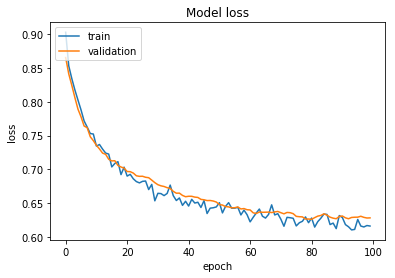

In [449]:
loss=h.history['loss']
val_loss=h.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
def save_model(model, name):
    m_dir = os.path.join('modelos')
    if not os.path.exists(m_dir):
        os.mkdir(m_dir)
    model.save(os.path.join(m_dir, "model_{}.h5".format(name)))
    print("Saved model to disk")

In [28]:
save_model(similarity_model, SAVE_PATH)

Saved model to disk


### Using the feature layers

In [29]:
def get_info(baseline, bug):
    info = np.concatenate((
        baseline.to_one_hot(bug['bug_severity'], baseline.info_dict['bug_severity']),
        baseline.to_one_hot(bug['bug_status'], baseline.info_dict['bug_status']),
        baseline.to_one_hot(bug['component'], baseline.info_dict['component']),
        baseline.to_one_hot(bug['priority'], baseline.info_dict['priority']),
        baseline.to_one_hot(bug['product'], baseline.info_dict['product']),
        baseline.to_one_hot(bug['version'], baseline.info_dict['version']))
    )
    return info

#### Similarity cosine 

In [475]:
def cosine_normalized(a, b):
    a = K.variable(a)
    b = K.variable(b)
    # normalization
    #a, a_norm = normalize(a)
    #b, b_norm = normalize(b)
    a_norm = K.sqrt(K.sum(K.square(a), axis=-1, keepdims=False))
    b_norm = K.sqrt(K.sum(K.square(b), axis=-1, keepdims=False))
    a_norm = K.maximum(a_norm, K.epsilon())
    b_norm = K.maximum(b_norm, K.epsilon())
    # dot
    #print("Var from mut", K.eval(a), K.eval(b))
    cos_sim = K.sum( a * b ) / (a_norm * b_norm)  
    #print("Mut", K.eval(cos_sim))
    return K.eval( (cos_sim + 1 ) / 2 )
    #return K.eval(cos_sim)[0], K.eval(K.sum(a * b)), K.eval(a_norm), K.eval(b_norm)
    
def cos_distance_keras(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.eval(K.mean(K.sum(y_true * y_pred, axis=-1)))

def cos_distance(y_true, y_pred):
    def l2_normalize(x, axis):
        norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
        return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())
    y_true = l2_normalize(y_true, axis=-1)
    y_pred = l2_normalize(y_pred, axis=-1)
    return K.eval(K.mean(y_true * y_pred))

def cos_custom(a, b):
    a = K.variable(a)
    b = K.variable(b)
    return K.eval(cosine_distance([a, b]))

bug_vector_a_t = np.random.rand(2)
bug_vector_b_t = -1.0 * np.random.rand(2)
# bug_vector_a_t = np.array([1.0, 1.0, 2.0])
# bug_vector_b_t = np.array([1.0, 2.0, 1.0])
bug_vector_a_t = np.array([0.0, 0.1, 0.0])
bug_vector_b_t = np.array([0.0, 0.1, 0.1])

print(bug_vector_a_t, bug_vector_b_t)

result = cos_distance(bug_vector_a_t, bug_vector_b_t)
result2 = cosine_normalized(bug_vector_a_t, bug_vector_b_t)
result3 = cos_distance_keras(bug_vector_a_t, bug_vector_b_t)
result4 = cos_custom(bug_vector_a_t, bug_vector_b_t)
result, result2, result3, result4

[0.  0.1 0. ] [0.  0.1 0.1]


(0.23570249609801194, 0.8535534, 0.7071067811865475, 0.8535538)

In [114]:
bug_vector_a_t = np.array([1, 1, 2])
bug_vector_b_t = np.array([1, 2, 1])
result = cos_custom(bug_vector_a_t, bug_vector_b_t)
result

0.9166666

#### Loading bugs of test

In [331]:
from scipy import spatial
bug_set = baseline.get_bug_set()
bug_id = [96204, np.random.choice(list(bug_set))] # non-duplicate {15196, 2}
# bug_id = [96204, 85581] # duplicate {85581, 96204, 106979}
dup_a, dup_b = bug_id
bug_a = bug_set[dup_a]
bug_b = bug_set[dup_b]

dup_a, dup_b

(96204, 331621)

#### LSTM feature

In [393]:
bug_a['title'], bug_b['title']

('preferences person text cut off using default fonts on organization',
 'workbench throws organization s on initial startup after install when bundles are started programmatically in country')

In [450]:
bug_vector_a_t = lstm_feature_model.predict(np.array([bug_a['title_word']]))[0]
bug_vector_b_t = lstm_feature_model.predict(np.array([bug_b['title_word']]))[0]
result = cosine_normalized(bug_vector_a_t, bug_vector_b_t)
result

0.91247654

In [451]:
bug_vector_a_t, bug_vector_b_t

(array([-0.00282953, -0.00264958, -0.00059295, -0.00770162,  0.01271654,
         0.01674974,  0.02468713,  0.00064883,  0.0161275 , -0.02451698,
         0.00120055, -0.01365429, -0.00643445,  0.04131409, -0.00900609,
         0.00861792, -0.01207932,  0.01442968,  0.01630557,  0.01642444,
         0.0104327 ,  0.01512857,  0.01394886,  0.02278541,  0.02598762,
        -0.02651976,  0.0155521 ,  0.01513479, -0.00610626,  0.01325812,
         0.00437862, -0.00691973, -0.03176214,  0.03304015,  0.01435195,
         0.00921452,  0.00993838,  0.01512022, -0.01952229,  0.02918823,
         0.03283456,  0.00182408,  0.03680788,  0.00039746,  0.01706651,
         0.00549139,  0.02018207,  0.00660156,  0.00720323,  0.02070285,
        -0.00172909,  0.03226786,  0.01150187,  0.01194593,  0.01412395,
         0.03660626,  0.0208211 ,  0.00219118,  0.0100699 ,  0.02143521,
         0.02106377,  0.01393883,  0.00426877,  0.00564931,  0.01254314,
         0.02394895,  0.03369314,  0.01836959,  0.0

#### CNN feature

In [452]:
bug_a['description'], bug_b['description']

('n the standard default font size for organization desktops is points at dpi at this size the message type filter text in the preferences dialog is being cut off',
 'person m our application runs on top of the organization product and we re seeing null pointer exceptions in the error log file when the it starts for the ordinal time after installation or with the clean option besides the exceptions there seems to be no ill effects and the exceptions do not occur in subsequent startups the problem seems to the related to starting bundles programmatically in our application s country istartup our application is starting the following bundles in country org mortbay jetty org eclipse equinox http jetty org eclipse equinox http registry com ibm nex rdparty spring spring lib org springframework bundle osgi core org springframework bundle osgi web org springframework bundle osgi extender org springframework bundle osgi io org eclipse equinox servletbridge this is the exception we re getting i

In [453]:
bug_vector_a_d = cnn_feature_model.predict(np.array([bug_a['description_word']]))[0]
bug_vector_b_d = cnn_feature_model.predict(np.array([bug_b['description_word']]))[0]
result = cosine_normalized(bug_vector_a_d, bug_vector_b_d)
result

0.73376

In [454]:
bug_vector_a_d, bug_vector_b_d

(array([-0.00396749,  0.00471156, -0.01426503,  0.00989036,  0.01445417,
         0.02637266,  0.0144034 ,  0.00127224, -0.00263252,  0.01979598,
        -0.00031477, -0.01317884, -0.02040865,  0.04631104,  0.00236373,
         0.00737801, -0.01847274, -0.0039616 ,  0.02243954,  0.01836502,
         0.00881222, -0.00179766,  0.01524902,  0.02508018,  0.01017696,
         0.01828573,  0.00842002,  0.00517623, -0.00155332,  0.00867846,
         0.00387428,  0.00922414,  0.01627133,  0.02530156,  0.02015509,
        -0.00528023, -0.00195644,  0.0200696 ,  0.02840973,  0.02030896,
         0.03969121, -0.00441934,  0.01447194,  0.00144587,  0.01559079,
        -0.01008179,  0.01206508, -0.00226536,  0.01466962,  0.02359793,
        -0.00326474,  0.03542634,  0.00694678,  0.00117312,  0.01467667,
         0.02289413,  0.023373  ,  0.00559076,  0.01592174, -0.00201561,
         0.01045073,  0.00380626,  0.00066235,  0.00963178,  0.01734725,
         0.01448634,  0.02795808,  0.01850062,  0.0

#### MLP feature

In [455]:
bug_vector_a_i = mlp_feature_model.predict(np.array([get_info(baseline, bug_a)]))[0]
bug_vector_b_i = mlp_feature_model.predict(np.array([get_info(baseline, bug_b)]))[0]
result = cosine_normalized(bug_vector_a_i, bug_vector_b_i)
result

0.9622007

In [456]:
bug_vector_a_i, bug_vector_b_i

(array([ 0.00898435,  0.00681827, -0.00683837,  0.01646446, -0.02190576,
        -0.03442217, -0.05441032, -0.01039835, -0.03624747,  0.0347992 ,
         0.00200615,  0.02896816,  0.01955191, -0.0947045 ,  0.01856618,
        -0.02672071,  0.0215764 , -0.01048286, -0.03507832, -0.02466301,
        -0.01546762, -0.0202019 , -0.0295802 , -0.04561544, -0.04962753,
         0.04072867, -0.03434861, -0.0285636 ,  0.00315032, -0.02382003,
         0.00557416,  0.00583649,  0.04092282, -0.06451617, -0.03196526,
        -0.00175807, -0.02959084, -0.03598869,  0.0219928 , -0.06110388,
        -0.06905239,  0.00229242, -0.0312892 ,  0.00158919, -0.02672325,
        -0.01136073, -0.04119809, -0.00931136, -0.02611517, -0.04890559,
         0.00614802, -0.06752473,  0.15556818, -0.0116523 , -0.03189664,
        -0.07712402, -0.04388608,  0.00461534, -0.02756989, -0.04276615,
        -0.03653626, -0.02455821, -0.00956913, -0.00447703, -0.02173263,
        -0.03055957, -0.06780569, -0.03909387, -0.0

#### Merge features

In [457]:
bug_vector_a = np.concatenate([ bug_vector_a_i, bug_vector_a_t, bug_vector_a_d ], -1)
bug_vector_b = np.concatenate([ bug_vector_b_i, bug_vector_b_t, bug_vector_b_d ], -1)
result = cosine_normalized(bug_vector_a, bug_vector_b)
result

0.9362024

In [402]:
bug_vector_a, bug_vector_b

(array([ 4.94681261e-02,  9.49203677e-04, -1.14025129e-03, -6.58509205e-04,
         8.55053663e-02, -4.40311758e-03,  1.33524148e-03,  1.65950149e-01,
         1.55633271e-01,  7.37797352e-04,  3.29904668e-02, -2.98296567e-03,
        -3.55361775e-03,  5.65805414e-04,  7.24802837e-02, -6.89411955e-03,
        -3.85972462e-03,  1.09431475e-01, -6.13609748e-03,  4.74855443e-03,
         1.55822386e-03, -5.38681576e-04, -4.71029402e-04, -4.83347801e-03,
        -3.16588371e-03, -1.66611858e-02, -3.87285952e-03,  8.65431502e-05,
         1.18778259e-01, -1.48626126e-03,  9.59881290e-04, -3.25306808e-03,
         1.05122908e-03,  1.41722355e-02, -5.75089315e-03,  1.03274465e-03,
        -7.69602600e-03,  7.12951063e-04,  3.21930833e-03, -4.07712394e-03,
         1.03924893e-01,  4.52048481e-02,  1.78002611e-01, -4.37792344e-03,
         4.61645046e-04,  9.28252644e-04, -3.21044074e-03,  7.33357738e-04,
        -1.66289730e-03,  2.01805115e-01, -6.39192713e-03, -8.82379338e-03,
        -3.1

### Retrieval evaluation

In [43]:
from methods.retrieval import Retrieval
from annoy import AnnoyIndex
import numpy as np

In [44]:
retrieval = Retrieval()

path = 'data/processed/{}'.format(DOMAIN)
path_buckets = 'data/normalized/{}/{}.csv'.format(DOMAIN, DOMAIN)
path_train = 'data/processed/{}/train.txt'.format(DOMAIN)
path_test = 'data/processed/{}/test.txt'.format(DOMAIN)

MAX_SEQUENCE_LENGTH_I = number_of_columns_info # Status, Severity, Version, Component, Module

# Create the instance from baseline
retrieval.baseline = Baseline(path, path_buckets, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

df = pd.read_csv(path_buckets)

# Load bug ids
retrieval.load_bugs(path, path_train)
# Create the buckets
retrieval.create_bucket(df)
# Read and create the test queries duplicate
retrieval.create_queries(path_test)

Reading train data
Reading the test...



Reading test data



Creating the buckets...



Creating the queries...


In [45]:
issues_by_buckets = {}
for bucket in tqdm(retrieval.buckets):
    issues_by_buckets[bucket] = bucket
    for issue in np.array(retrieval.buckets[bucket]).tolist():
        issues_by_buckets[issue] = bucket

In [46]:
retrieval.train_vectorized, retrieval.test_result = [], []
# Infer vector to all train
retrieval.read_train(path_train)

In [47]:
print("Total of queries:", len(retrieval.test))

Total of queries: 12659


#### Selecting bugs from test

In [48]:
buckets_train = set()
for row in tqdm(retrieval.test):
    bug_id, ground_truth = row
    vectorizer = [bug_id] 
    vectorizer += ground_truth
    for test_bug_id in vectorizer:
        buckets_train.add(issues_by_buckets[test_bug_id])

#### Model to vectorize

In [458]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model

bug_title =  similarity_model.get_layer('title_in').input 
bug_desc =  similarity_model.get_layer('desc_in').input 
bug_info = similarity_model.get_layer('info_in').input 

title_encoder = similarity_model.get_layer('FeatureLstmGenerationModel')
desc_encoder = similarity_model.get_layer('FeatureCNNGenerationModel')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')

bug_t = title_encoder(bug_title)
bug_d = desc_encoder(bug_desc)
bug_i = info_encoder(bug_info)
# Representation layer
model = similarity_model.get_layer('merge_features_in')
output = model([bug_i, bug_t, bug_d])
# Bug Representation
# bug_model = similarity_model.get_layer('dense_4')
# output = bug_model(output)
# Normalization
# model_normalized = similarity_model.get_layer('normalize_encoded_anchor')
# output = model_normalized(output)

model = Model(inputs=[bug_title, bug_desc, bug_info], outputs=[output])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [459]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_in (InputLayer)            (None, 1682)         0                                            
__________________________________________________________________________________________________
title_in (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
FeatureMlpGenerationModel (Mode (None, 100)          168300      info_in[0][0]                    
__________________________________________________________________________________________________
FeatureLst

#### Vectorizing bugs from train

In [460]:
def vectorizer_buckets_train(buckets_train):
    bug_set = retrieval.baseline.get_bug_set()
    buckets_train_vectorized = []
    for bug_id in tqdm(buckets_train): # retrieval.bugs_train
        bug = bug_set[bug_id]
        bug_vector = model.predict([ [bug['title_word']], [bug['description_word']], [retrieval.get_info(bug)] ])[0]
        buckets_train_vectorized.append({ 'bug_id' : bug_id, 'vector' : bug_vector })
    return buckets_train_vectorized

In [461]:
buckets_train_vectorized = vectorizer_buckets_train(buckets_train)

#### Vectorizing bugs from test

In [462]:
bug_set = retrieval.baseline.get_bug_set()
queries_test_vectorized = []
for row in tqdm(retrieval.test):
    bug_id, ground_truth = row
    vectorizer = [bug_id] 
    vectorizer += ground_truth
    for test_bug_id in vectorizer:
        if issues_by_buckets[test_bug_id] == test_bug_id: continue # if the bug is the master
        bug = bug_set[test_bug_id]
        bug_vector = model.predict([ [bug['title_word']], [bug['description_word']], [retrieval.get_info(bug)] ])[0]
        queries_test_vectorized.append({ 'bug_id' : test_bug_id, 'vector' : bug_vector,
                                        'ground_truth': issues_by_buckets[test_bug_id] })

#### Indexing bugs

In [463]:
# Indexing all train
def indexing_train(buckets_train_vectorized):
    X = np.array(buckets_train_vectorized)
    annoy = AnnoyIndex(X[0]['vector'].shape[0])  # Length of item vector that will be indexed

    loop = tqdm(total=len(X))
    for index, row in enumerate(X):
        vector = row['vector']
        annoy.add_item(index, vector)
        loop.update(1)
    loop.close()
    annoy.build(10) # 10 trees
    return annoy

In [464]:
annoy = indexing_train(buckets_train_vectorized)

#### Getting the list of candidates

In [465]:
def indexing_test(queries_test_vectorized):
    X_test = queries_test_vectorized
    distance_test, indices_test = [], []
    for index, row in tqdm(enumerate(X_test)):
        vector = row['vector']
        rank, dist = annoy.get_nns_by_vector(vector, 30, include_distances=True)
        indices_test.append(rank)
        distance_test.append(1 - np.array(dist)) # normalize the similarity between 0 and 1
    return X_test, distance_test, indices_test

In [466]:
X_test, distance_test, indices_test = indexing_test(queries_test_vectorized)

In [467]:
print("Total buckets train vectorized: {}".format(len(buckets_train_vectorized)))
print("Total queries vectorized: {}".format(len(queries_test_vectorized)))

Total buckets train vectorized: 7875
Total queries vectorized: 22740


### Rank result

In [468]:
formated_rank = []
for row_index, row_sim in tqdm(zip(indices_test, distance_test)):
    row_index, row_sim = row_index[:25], row_sim[:25]
    formated_rank.append(",".join(["{}:{}".format(buckets_train_vectorized[index]['bug_id'], sim) 
                                   for index, sim in zip(row_index, row_sim)]))

#### Queries

In [469]:
# Generating the rank result
rank_queries = []

for index, row in tqdm(enumerate(X_test)):
    dup_a, ground_truth = row['bug_id'], row['ground_truth']
    rank_queries.append("{}:{}".format(dup_a, ground_truth))

In [470]:
exported_rank = []
loop = tqdm(total=len(rank_queries))

for query, rank in zip(rank_queries, formated_rank):
    exported_rank.append("{}|{}".format(query, rank))
    loop.update(1)
loop.close()

In [471]:
exported_rank[:20]

['324658:327681|237946:0.7465885281562805,174371:0.7375487089157104,299964:0.7332021594047546,75012:0.7294976115226746,92530:0.7209718823432922,76849:0.7179231345653534,230050:0.7167859673500061,80468:0.7154443860054016,147859:0.7072057127952576,83094:0.7023777365684509,74796:0.6972540318965912,99000:0.6880378127098083,147921:0.675367534160614,231565:0.6731622219085693,166025:0.6718645691871643,82667:0.6715452671051025,112750:0.6701945662498474,170279:0.6687762439250946,228747:0.668235570192337,76699:0.6679707467556,108059:0.6674296855926514,171288:0.663710206747055,74949:0.663425624370575,153444:0.6623133420944214,193839:0.6598970890045166',
 '327682:307170|50517:0.9218058362603188,70390:0.916960671544075,97600:0.9144133776426315,34165:0.914031870663166,57634:0.9132541567087173,66228:0.912049226462841,47092:0.9117005616426468,87263:0.911373682320118,70391:0.9092582538723946,41975:0.908260852098465,49707:0.9078447222709656,178309:0.9070352390408516,259763:0.9066686257719994,61922:0.905

In [472]:
with open(os.path.join(path, 'exported_rank.txt'), 'w') as file_out:
    for row in exported_rank:
        file_out.write(row + "\n")

In [473]:
class Evaluation():
    def __init__(self):
        pass
    
    """
        Rank recall_rate_@k
        rank = "query:master|master:id:sim,master:id:sim"
    """
    def top_k_recall(self, rank, k):
        query, rank = rank.split('|')
        query_dup_id, query_master = query.split(":")
        query_master = int(query_master)
        rank_masters = [int(item.split(':')[0]) for pos, item in enumerate(rank.split(",")[:20])]
        corrects = len(set([query_master]) & set(rank_masters[:k]))
        #total = len(retrieval.buckets[issues_by_buckets[query_master]])
        total = 1 if corrects <= 0 else corrects
        return float(corrects), total

    def evaluate(self, path):
        recall_at_5_corrects_sum, recall_at_10_corrects_sum, \
        recall_at_15_corrects_sum, recall_at_20_corrects_sum, recall_at_25_corrects_sum = 0, 0, 0, 0, 0
        recall_at_5_total_sum, recall_at_10_total_sum, recall_at_15_total_sum, \
        recall_at_20_total_sum, recall_at_25_total_sum = 0, 0, 0, 0, 0 
        print("Evaluating...")
        with open(path, 'r') as file_input:
            for row in file_input:
                #if row == '': continue
                recall_at_5_corrects, recall_at_5_total = self.top_k_recall(row, k=5)
                recall_at_10_corrects, recall_at_10_total = self.top_k_recall(row, k=10)
                recall_at_15_corrects, recall_at_15_total = self.top_k_recall(row, k=15)
                recall_at_20_corrects, recall_at_20_total = self.top_k_recall(row, k=20)
                recall_at_25_corrects, recall_at_25_total = self.top_k_recall(row, k=25)
                
                recall_at_5_corrects_sum += recall_at_5_corrects
                recall_at_10_corrects_sum += recall_at_10_corrects
                recall_at_15_corrects_sum += recall_at_15_corrects
                recall_at_20_corrects_sum += recall_at_20_corrects
                recall_at_25_corrects_sum += recall_at_25_corrects
                
                recall_at_5_total_sum += recall_at_5_total
                recall_at_10_total_sum += recall_at_10_total
                recall_at_15_total_sum += recall_at_15_total
                recall_at_20_total_sum += recall_at_20_total
                recall_at_25_total_sum += recall_at_25_total
        
        report = {
            '1 - recall_at_5' : round(recall_at_5_corrects_sum / recall_at_5_total_sum, 2),
            '2 - recall_at_10' : round(recall_at_10_corrects_sum / recall_at_10_total_sum, 2),
            '3 - recall_at_15' : round(recall_at_15_corrects_sum / recall_at_15_total_sum, 2),
            '4 - recall_at_20' : round(recall_at_20_corrects_sum / recall_at_20_total_sum, 2),
            '5 - recall_at_25' : round(recall_at_25_corrects_sum / recall_at_25_total_sum, 2)
        }

        return report

In [474]:
'''
    With CNN print all embeddings zero and 2 epochs
    {'1 - recall_at_5': 0.13,
     '2 - recall_at_10': 0.18,
     '3 - recall_at_15': 0.22,
     '4 - recall_at_20': 0.24}
     Without relu activation for each feature siamese in 100 epochs
     {'1 - recall_at_5': 0.16,
     '2 - recall_at_10': 0.23,
     '3 - recall_at_15': 0.27,
     '4 - recall_at_20': 0.31}
     Without dense in the last layer with 100 epochs with embed trainable
     {'1 - recall_at_5': 0.16,
     '2 - recall_at_10': 0.22,
     '3 - recall_at_15': 0.26,
     '4 - recall_at_20': 0.3}
      
      {'1 - recall_at_5': 0.16,
         '2 - recall_at_10': 0.22,
         '3 - recall_at_15': 0.26,
         '4 - recall_at_20': 0.29,
         '5 - recall_at_25': 0.29}
'''
evaluation = Evaluation()
report = evaluation.evaluate(os.path.join(path, 'exported_rank.txt'))
report

Evaluating...


{'1 - recall_at_5': 0.16,
 '2 - recall_at_10': 0.21,
 '3 - recall_at_15': 0.25,
 '4 - recall_at_20': 0.28,
 '5 - recall_at_25': 0.28}